# Py - RTTOV

[PDF Python Interface Guide - NWP/SAF](https://nwp-saf.eumetsat.int/site/download/documentation/rtm/docs_rttov12/rttov-wrapper.pdf)



In [1]:
# System information
import numpy as np
import matplotlib.pyplot as plt
import os, sys, glob
import pandas as pd
import xarray
import h5py
import pickle
import netCDF4 as nc
import multiprocessing
from functools import partial
import datetime


pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
plt.rcParams['figure.figsize'] = [12, 8]

# System information
def to_days_since(time):
    reference = datetime.datetime(1900, 1, 1)
    fstart = datetime.datetime(int(str(time)[:4]),int(str(time)[-2:]),15)
    offset = fstart - reference
    return offset.days

/tmp/ipykernel_2654896/797059244.py:18: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
def compare_msu(re, da, channel, rss_file, plot_color = 'blue',station_lat = 48.20, station_lon = 16.37, anomaly = False, anomaly_s = 1981, anomaly_e = 2011):
    
    dates = []
    for i in range(len(da)):
        dates.append(pd.to_datetime(str(da[i])[:4]+'-'+str(da[i])[4:]))

    time = pd.to_datetime('1978-1-1 0:0:0')    
    if anomaly:
        mean = [0]*12
        count = [0]*12
        yrlist = [i for i in range(anomaly_s,anomaly_e + 1 )]
        for i in range(len(re)):
            if int(str(da[i])[:4]) in yrlist:
                if not isinstance(re[i], float):
                    for j in range(1,13):
                        if not np.isnan(re[i][0][channel]):
                            if j == int(str(da[i])[-2:]):
                                mean[j-1] += re[i][0][channel]
                                count[j-1] += 1
        for j in range(1,13):
            mean[j-1] = mean[j-1]/count[j-1]

        
#     for i in range(len(re)):
#         if not isinstance(re[i], float):
#             if not np.isnan(re[i][0][0]):
#                 if anomaly:
#                     for j in range(1,13):
#                         if j == int(str(da[i])[-2:]):
#                             re[i][0][channel] -= mean[j-1]

#                 else:
#                     re[i][0][channel] -= 0

#         else:
#             re[i] = [[np.nan, np.nan, np.nan]]

    a = np.resize(re,(len(re),3))

    plt.rcParams['figure.figsize'] = [12, 8]

    fig, ax = plt.subplots()

    ax.grid()
    if anomaly:
        ax.set(xlabel='date', ylabel='reflectivity anomaly [K]',
           title='Anomaly MSU_'+str(channel + 2))
    else:
        ax.set(xlabel='date', ylabel='reflectivity [K]',
           title='AMSU-B_'+str(channel + 18))
    ax.plot(dates, a[:,channel], color=plot_color, label='AMSU-B_'+str(channel + 18), linewidth=4, alpha=0.8)
    ax.plot(rss_file[0], rss_file[1], color='black', label='Fiduceo')
    ax.legend()

    fig.tight_layout(pad=2.0)
    plt.show()
    plt.close()

In [3]:
a = glob.glob('./fiduceo/out/amsub_15/*Ch18*')
a = np.sort(a)
refls_amsub15_18 = []
dates_amsub15_18 = []
for i in a:
    try:
        refls_amsub15_18.append(pickle.load( open( i, "rb" ) )[0])
    except:
        refls_amsub15_18.append(np.nan)
    date = i.split('_')[6:8]
    dates_amsub15_18.append(pd.to_datetime(date[0]+'-'+date[1]+'-'+'01'))

a = glob.glob('./fiduceo/out/amsub_15/*Ch19*')
a = np.sort(a)
refls_amsub15_19 = []
dates_amsub15_19 = []
for i in a:
    try:
        refls_amsub15_19.append(pickle.load( open( i, "rb" ) )[0])
    except:
        refls_amsub15_19.append(np.nan)
    date = i.split('_')[6:8]
    dates_amsub15_19.append(pd.to_datetime(date[0]+'-'+date[1]+'-'+'01'))
    
a = glob.glob('./fiduceo/out/amsub_15/*Ch20*')
a = np.sort(a)
refls_amsub15_20 = []
dates_amsub15_20 = []
for i in a:
    try:
        refls_amsub15_20.append(pickle.load( open( i, "rb" ) )[0])
    except:
        refls_amsub15_20.append(np.nan)
    date = i.split('_')[6:8]
    dates_amsub15_20.append(pd.to_datetime(date[0]+'-'+date[1]+'-'+'01'))

In [4]:
a = glob.glob('./fiduceo/out/amsub_16/*Ch18*')
a = np.sort(a)
refls_amsub16_18 = []
dates_amsub16_18 = []
for i in a:
    try:
        refls_amsub16_18.append(pickle.load( open( i, "rb" ) )[0])
    except:
        refls_amsub16_18.append(np.nan)
    date = i.split('_')[6:8]
    dates_amsub16_18.append(pd.to_datetime(date[0]+'-'+date[1]+'-'+'01'))

a = glob.glob('./fiduceo/out/amsub_16/*Ch19*')
a = np.sort(a)
refls_amsub16_19 = []
dates_amsub16_19 = []
for i in a:
    try:
        refls_amsub16_19.append(pickle.load( open( i, "rb" ) )[0])
    except:
        refls_amsub16_19.append(np.nan)
    date = i.split('_')[6:8]
    dates_amsub16_19.append(pd.to_datetime(date[0]+'-'+date[1]+'-'+'01'))
    
a = glob.glob('./fiduceo/out/amsub_16/*Ch20*')
a = np.sort(a)
refls_amsub16_20 = []
dates_amsub16_20 = []
for i in a:
    try:
        refls_amsub16_20.append(pickle.load( open( i, "rb" ) )[0])
    except:
        refls_amsub16_20.append(np.nan)
    date = i.split('_')[6:8]
    dates_amsub16_20.append(pd.to_datetime(date[0]+'-'+date[1]+'-'+'01'))

In [5]:
a = glob.glob('./fiduceo/out/mhs_19/*Ch3*')
a = np.sort(a)
refls_mhs19_3 = []
dates_mhs19_3 = []
for i in a:
    try:
        refls_mhs19_3.append(pickle.load( open( i, "rb" ) )[0])
    except:
        refls_mhs19_3.append(np.nan)
    date = i.split('_')[6:8]
    dates_mhs19_3.append(pd.to_datetime(date[0]+'-'+date[1]+'-'+'01'))

a = glob.glob('./fiduceo/out/mhs_19/*Ch4*')
a = np.sort(a)
refls_mhs19_4 = []
dates_mhs19_4 = []
for i in a:
    try:
        refls_mhs19_4.append(pickle.load( open( i, "rb" ) )[0])
    except:
        refls_mhs19_4.append(np.nan)
    date = i.split('_')[6:8]
    dates_mhs19_4.append(pd.to_datetime(date[0]+'-'+date[1]+'-'+'01'))
    
a = glob.glob('./fiduceo/out/mhs_19/*Ch5*')
a = np.sort(a)
refls_mhs19_5 = []
dates_mhs19_5 = []
for i in a:
    try:
        refls_mhs19_5.append(pickle.load( open( i, "rb" ) )[0])
    except:
        refls_mhs19_5.append(np.nan)
    date = i.split('_')[6:8]
    dates_mhs19_5.append(pd.to_datetime(date[0]+'-'+date[1]+'-'+'01'))

In [6]:
stat="11035"
re = pickle.load( open( "./rttov_out_hum_noaa_15_amsub/"+stat+"/"+stat+"_day_refl.p", "rb" ) )
da = pickle.load( open( "./rttov_out_hum_noaa_15_amsub/"+stat+"/"+stat+"_day_dates.p", "rb" ) )
refl = np.resize(re,(len(re),3))
refl_15_18 = refl[:,0]
dates_15_18 = []
for i in range(len(da)):
    dates_15_18.append(pd.to_datetime(str(da[i])[:4]+'-'+str(da[i])[4:]))

refl_15_19 = refl[:,1]
dates_15_19 = dates_15_18

refl_15_20 = refl[:,2]
dates_15_20 = dates_15_18


In [7]:
stat="11035"
re = pickle.load( open( "./rttov_out_hum_noaa_16_amsub/"+stat+"/"+stat+"_day_refl.p", "rb" ) )
da = pickle.load( open( "./rttov_out_hum_noaa_16_amsub/"+stat+"/"+stat+"_day_dates.p", "rb" ) )
refl = np.resize(re,(len(re),3))
refl_16_18 = refl[:,0]
dates_16_18 = []
for i in range(len(da)):
    dates_16_18.append(pd.to_datetime(str(da[i])[:4]+'-'+str(da[i])[4:]))

refl_16_19 = refl[:,1]
dates_16_19 = dates_16_18

refl_16_20 = refl[:,2]
dates_16_20 = dates_16_18

In [8]:
stat="11035"
re = pickle.load( open( "./rttov_out_hum_noaa_17_amsub/"+stat+"/"+stat+"_day_refl.p", "rb" ) )
da = pickle.load( open( "./rttov_out_hum_noaa_17_amsub/"+stat+"/"+stat+"_day_dates.p", "rb" ) )
refl = np.resize(re,(len(re),3))
refl_17_18 = refl[:,0]
dates_17_18 = []
for i in range(len(da)):
    dates_17_18.append(pd.to_datetime(str(da[i])[:4]+'-'+str(da[i])[4:]))

refl_17_19 = refl[:,1]
dates_17_19 = dates_17_18

refl_17_20 = refl[:,2]
dates_17_20 = dates_17_18

In [9]:
stat="11035"
re = pickle.load( open( "./rttov_out_hum_noaa_19_mhs/"+stat+"/"+stat+"_day_refl.p", "rb" ) )
da = pickle.load( open( "./rttov_out_hum_noaa_19_mhs/"+stat+"/"+stat+"_day_dates.p", "rb" ) )
refl = np.resize(re,(len(re),3))
refl_19_3 = refl[:,0]
dates_19_3 = []
for i in range(len(da)):
    dates_19_3.append(pd.to_datetime(str(da[i])[:4]+'-'+str(da[i])[4:]))

refl_19_4 = refl[:,1]
dates_19_4 = dates_19_3

refl_19_5 = refl[:,2]
dates_19_5 = dates_19_3

## RTTOV to Satellite Data Comparison

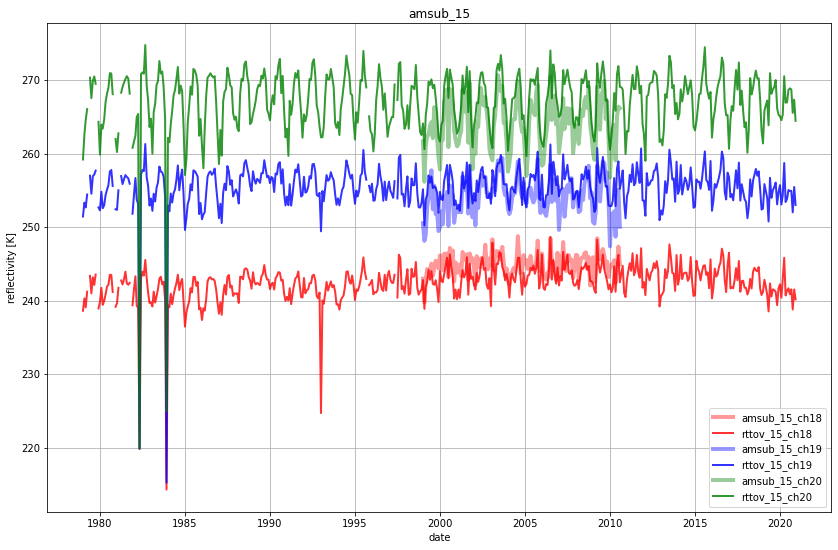

In [10]:
fig, ax = plt.subplots()
ax.grid()
ax.set(xlabel='date', ylabel='reflectivity [K]',
   title='amsub_15')
ax.plot(dates_amsub15_18, refls_amsub15_18, color='red', label='amsub_15_ch18', linewidth=4, alpha=0.4)
ax.plot(dates_15_18, refl_15_18, color='red', label='rttov_15_ch18', linewidth=2, alpha=0.8)
ax.plot(dates_amsub15_19, refls_amsub15_19, color='blue', label='amsub_15_ch19', linewidth=4, alpha=0.4)
ax.plot(dates_15_19, refl_15_19, color='blue', label='rttov_15_ch19', linewidth=2, alpha=0.8)
ax.plot(dates_amsub15_18, refls_amsub15_20, color='green', label='amsub_15_ch20', linewidth=4, alpha=0.4)
ax.plot(dates_15_20, refl_15_20, color='green', label='rttov_15_ch20', linewidth=2, alpha=0.8)
ax.legend()
fig.tight_layout(pad=2.0)
plt.show()
plt.close()

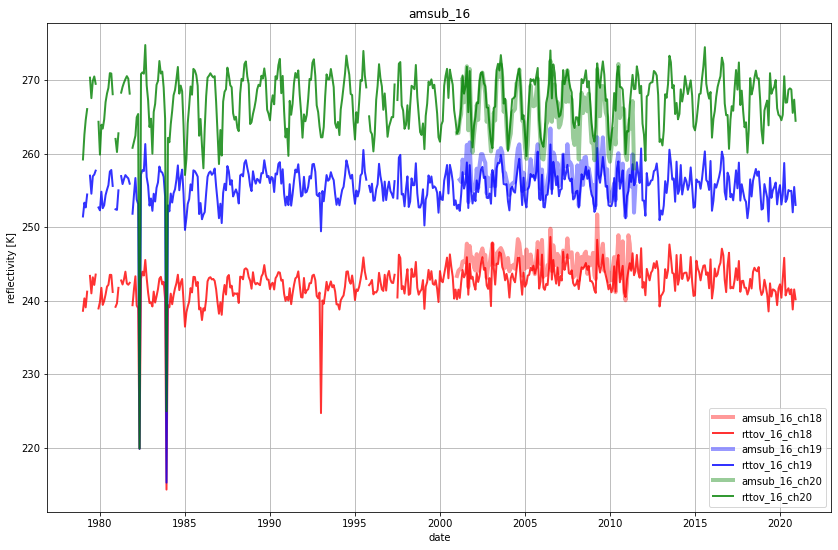

In [11]:
fig, ax = plt.subplots()
ax.grid()
ax.set(xlabel='date', ylabel='reflectivity [K]',
   title='amsub_16')
ax.plot(dates_amsub16_18, refls_amsub16_18, color='red', label='amsub_16_ch18', linewidth=4, alpha=0.4)
ax.plot(dates_16_18, refl_16_18, color='red', label='rttov_16_ch18', linewidth=2, alpha=0.8)
ax.plot(dates_amsub16_19, refls_amsub16_19, color='blue', label='amsub_16_ch19', linewidth=4, alpha=0.4)
ax.plot(dates_16_19, refl_16_19, color='blue', label='rttov_16_ch19', linewidth=2, alpha=0.8)
ax.plot(dates_amsub16_18, refls_amsub16_20, color='green', label='amsub_16_ch20', linewidth=4, alpha=0.4)
ax.plot(dates_16_20, refl_16_20, color='green', label='rttov_16_ch20', linewidth=2, alpha=0.8)
ax.legend()
fig.tight_layout(pad=2.0)
plt.show()
plt.close()

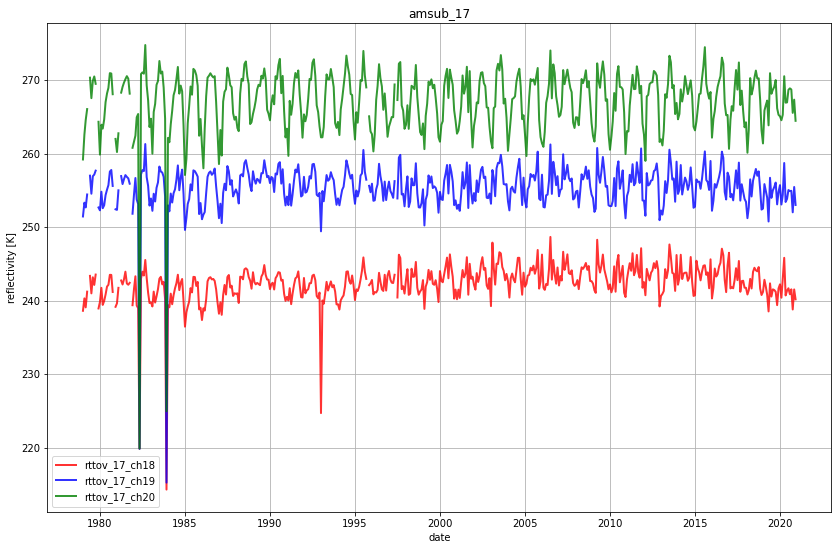

In [12]:
fig, ax = plt.subplots()
ax.grid()
ax.set(xlabel='date', ylabel='reflectivity [K]',
   title='amsub_17')
# ax.plot(dates_amsub17_18, refls_amsub17_18, color='red', label='amsub_17_ch18', linewidth=4, alpha=0.4)
ax.plot(dates_17_18, refl_17_18, color='red', label='rttov_17_ch18', linewidth=2, alpha=0.8)
# ax.plot(dates_amsub17_19, refls_amsub17_19, color='blue', label='amsub_17_ch19', linewidth=4, alpha=0.4)
ax.plot(dates_17_19, refl_17_19, color='blue', label='rttov_17_ch19', linewidth=2, alpha=0.8)
# ax.plot(dates_amsub17_18, refls_amsub17_20, color='green', label='amsub_17_ch20', linewidth=4, alpha=0.4)
ax.plot(dates_17_20, refl_17_20, color='green', label='rttov_17_ch20', linewidth=2, alpha=0.8)
ax.legend()
fig.tight_layout(pad=2.0)
plt.show()
plt.close()

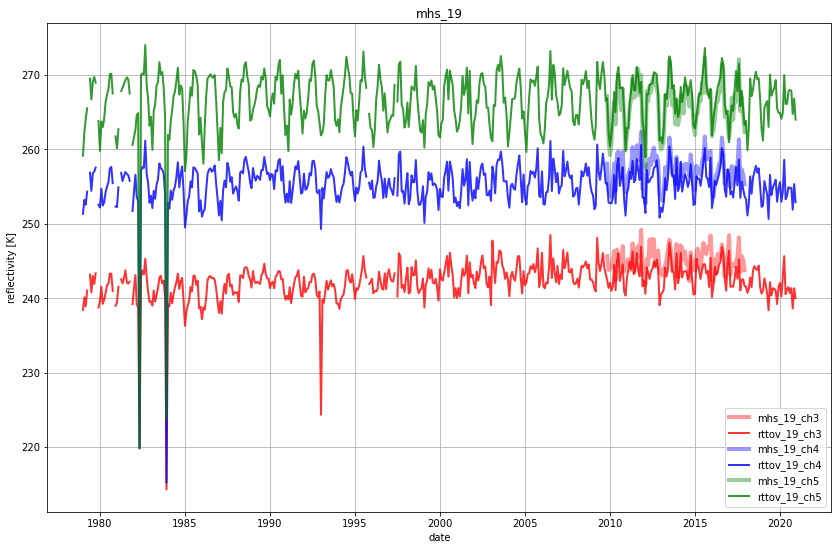

In [13]:
fig, ax = plt.subplots()
ax.grid()
ax.set(xlabel='date', ylabel='reflectivity [K]',
   title='mhs_19')
ax.plot(dates_mhs19_3, refls_mhs19_3, color='red', label='mhs_19_ch3', linewidth=4, alpha=0.4)
ax.plot(dates_19_3, refl_19_3, color='red', label='rttov_19_ch3', linewidth=2, alpha=0.8)
ax.plot(dates_mhs19_4, refls_mhs19_4, color='blue', label='mhs_19_ch4', linewidth=4, alpha=0.4)
ax.plot(dates_19_4, refl_19_4, color='blue', label='rttov_19_ch4', linewidth=2, alpha=0.8)
ax.plot(dates_mhs19_5, refls_mhs19_5, color='green', label='mhs_19_ch5', linewidth=4, alpha=0.4)
ax.plot(dates_19_5, refl_19_5, color='green', label='rttov_19_ch5', linewidth=2, alpha=0.8)
ax.legend()
fig.tight_layout(pad=2.0)
plt.show()
plt.close()

## Satellite Data Comparison

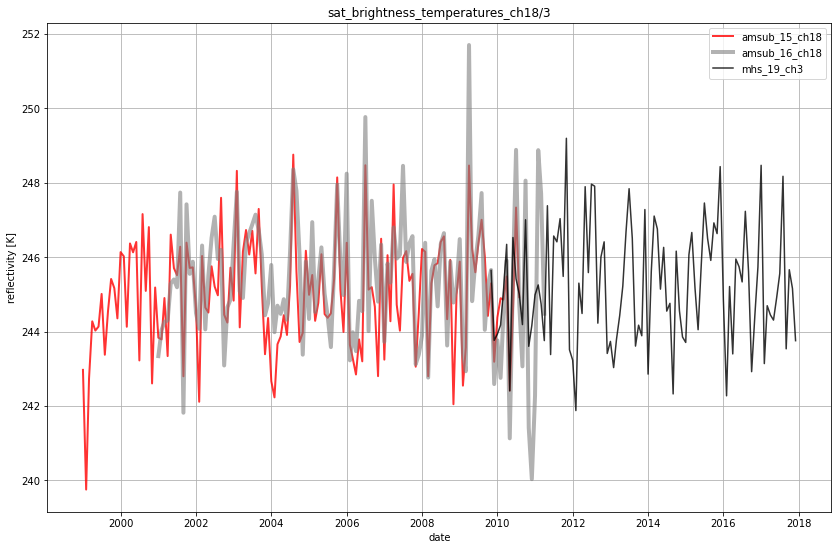

In [14]:
fig, ax = plt.subplots()
ax.grid()
ax.set(xlabel='date', ylabel='reflectivity [K]',
   title='sat_brightness_temperatures_ch18/3')
ax.plot(dates_amsub15_18, refls_amsub15_18, color='red', label='amsub_15_ch18', linewidth=2, alpha=0.8)
ax.plot(dates_amsub16_18, refls_amsub16_18, color='grey', label='amsub_16_ch18', linewidth=4, alpha=0.6)
ax.plot(dates_mhs19_3, refls_mhs19_3, color='black', label='mhs_19_ch3', linewidth=1.5, alpha=0.8)

ax.legend()

fig.tight_layout(pad=2.0)
plt.show()
plt.close()

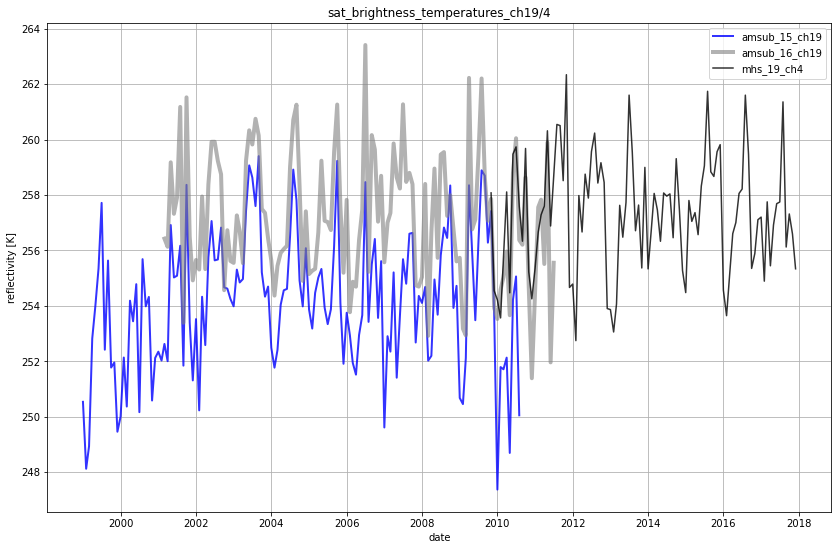

In [15]:
fig, ax = plt.subplots()
ax.grid()
ax.set(xlabel='date', ylabel='reflectivity [K]',
   title='sat_brightness_temperatures_ch19/4')

ax.plot(dates_amsub15_19, refls_amsub15_19, color='blue', label='amsub_15_ch19', linewidth=2, alpha=0.8)
ax.plot(dates_amsub16_19, refls_amsub16_19, color='grey', label='amsub_16_ch19', linewidth=4, alpha=0.6)
ax.plot(dates_mhs19_4, refls_mhs19_4, color='black', label='mhs_19_ch4', linewidth=1.5, alpha=0.8)

ax.legend()

fig.tight_layout(pad=2.0)
plt.show()
plt.close()

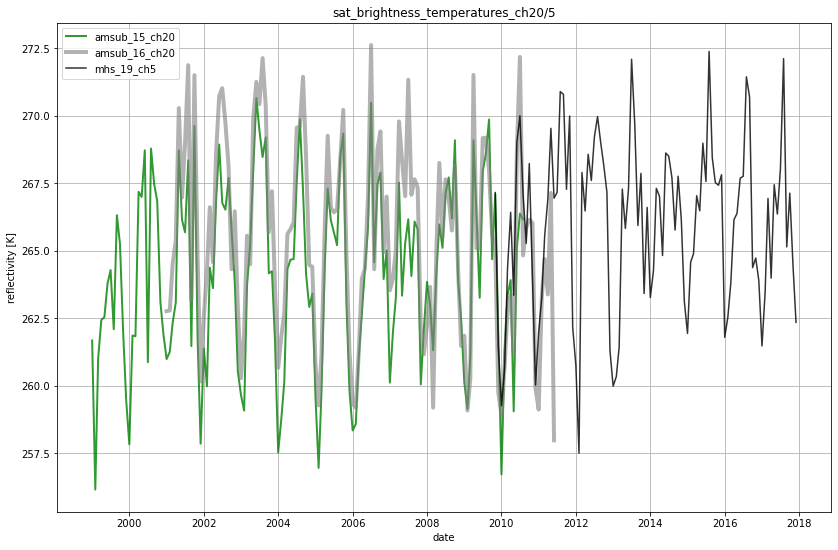

In [16]:
fig, ax = plt.subplots()
ax.grid()
ax.set(xlabel='date', ylabel='reflectivity [K]',
   title='sat_brightness_temperatures_ch20/5')

ax.plot(dates_amsub15_20, refls_amsub15_20, color='green', label='amsub_15_ch20', linewidth=2, alpha=0.8)
ax.plot(dates_amsub16_20, refls_amsub16_20, color='grey', label='amsub_16_ch20', linewidth=4, alpha=0.6)
ax.plot(dates_mhs19_5, refls_mhs19_5, color='black', label='mhs_19_ch5', linewidth=1.5, alpha=0.8)

ax.legend()

fig.tight_layout(pad=2.0)
plt.show()
plt.close()

## RTTOV Comparison

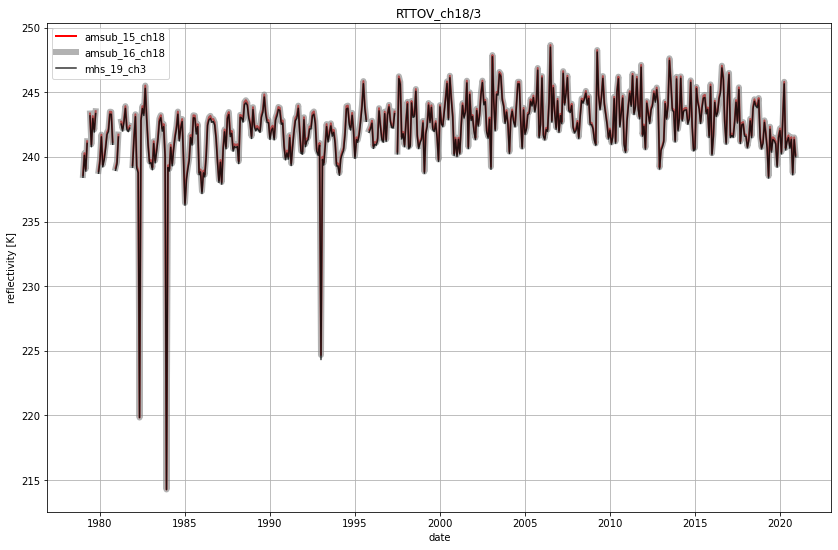

In [17]:
fig, ax = plt.subplots()
ax.grid()
ax.set(xlabel='date', ylabel='reflectivity [K]',
   title='RTTOV_ch18/3')

ax.plot(dates_15_18, refl_15_18, color='red', label='amsub_15_ch18', linewidth=2, alpha=1)
ax.plot(dates_16_18, refl_16_18, color='grey', label='amsub_16_ch18', linewidth=6, alpha=0.6)
ax.plot(dates_19_3, refl_19_3, color='black', label='mhs_19_ch3', linewidth=1.5, alpha=0.8)

ax.legend()

fig.tight_layout(pad=2.0)
plt.show()
plt.close()

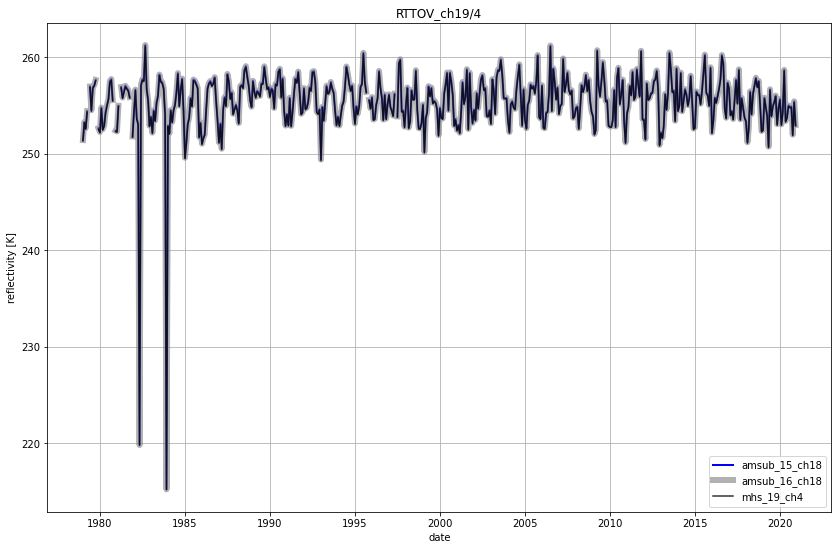

In [18]:
fig, ax = plt.subplots()
ax.grid()
ax.set(xlabel='date', ylabel='reflectivity [K]',
   title='RTTOV_ch19/4')

ax.plot(dates_15_19, refl_15_19, color='blue', label='amsub_15_ch18', linewidth=2, alpha=1)
ax.plot(dates_16_19, refl_16_19, color='grey', label='amsub_16_ch18', linewidth=6, alpha=0.6)
ax.plot(dates_19_4, refl_19_4, color='black', label='mhs_19_ch4', linewidth=1.5, alpha=0.8)

ax.legend()

fig.tight_layout(pad=2.0)
plt.show()
plt.close()

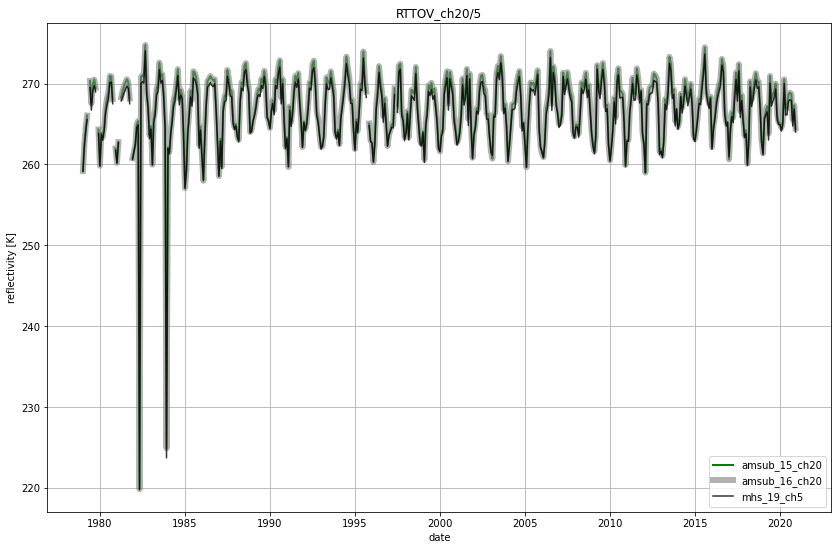

In [19]:
fig, ax = plt.subplots()
ax.grid()
ax.set(xlabel='date', ylabel='reflectivity [K]',
   title='RTTOV_ch20/5')

ax.plot(dates_15_20, refl_15_20, color='green', label='amsub_15_ch20', linewidth=2, alpha=1)
ax.plot(dates_16_20, refl_16_20, color='grey', label='amsub_16_ch20', linewidth=6, alpha=0.6)
ax.plot(dates_19_5, refl_19_5, color='black', label='mhs_19_ch5', linewidth=1.5, alpha=0.8)

ax.legend()

fig.tight_layout(pad=2.0)
plt.show()
plt.close()